# Predicting Flight Delays

In this notebook, we use the combined flight delay and weather data we have created to create and evaluate models to predict flight delays.

**Note** the full flight delay dataset is very large (over 80GB uncompressed), so we are working with a smaller sample dataset. Hence our results may not be a true reflection of the results on the full dataset.

#### Import required modules

Import and configure the required modules.

In [1]:
!pip install seaborn scikit-learn > /dev/null 2>&1

In [2]:
# Define required imports
import json
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style='darkgrid', palette='deep')
# These set pandas max column and row display in the notebook
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 50)

In [3]:
MODEL_EXPORT_FOLDER = 'models'
from pathlib import Path
export_path = Path(MODEL_EXPORT_FOLDER)
export_path.mkdir(parents=True, exist_ok=True)

### Read the data

We start by reading in the merged flight delay and weather data

In [4]:
flight_path = 'data/jfk_flight_weather_features.csv'
flight_data = pd.read_csv(flight_path, parse_dates=['flight_date'])
flight_data.head()

,flight_date,month,day_of_month,day_of_week,airline_id,airline_name,origin,dest,sched_dep_time,dep_time_bin,distance_bin,delayed,dep_delay,hour_key,date_key,DATE,visibility,weather_type_raw,wind_speed,wind_gust_speed,precip,rain,ice_pellets,mist,snow,drizzle,haze,fog,thunderstorm,smoke,unknown_precipitation
0,2015-03-17,3,17,2,20409,JetBlue,JFK,RSW,1525,1500-1559,5,0,-7,14,2015-03-17,2015-03-17 14:51:00,10.0,NaN,30,9,0.0,0,0,0,0,0,0,0,0,0,0
1,2016-05-25,5,25,3,20409,JetBlue,JFK,SJU,2119,2100-2159,7,0,0,20,2016-05-25,2016-05-25 20:51:00,10.0,NaN,11,0,0.0,0,0,0,0,0,0,0,0,0,0
2,2017-07-26,7,26,3,19805,American Airlines,JFK,SFO,700,0700-0759,11,0,-3,6,2017-07-26,2017-07-26 06:51:00,10.0,NaN,7,0,0.0,0,0,0,0,0,0,0,0,0,0
3,2010-12-11,12,11,6,20409,JetBlue,JFK,LAS,1900,1900-1959,9,0,-5,18,2010-12-11,2010-12-11 18:51:00,10.0,NaN,3,0,0.0,0,0,0,0,0,0,0,0,0,0
4,2012-08-11,8,11,6,20398,Envoy Air,JFK,IND,1510,1500-1559,3,0,-2,14,2012-08-11,2012-08-11 14:51:00,10.0,NaN,18,0,0.0,0,0,0,0,0,0,0,0,0,0


In [5]:
flight_data['dest'].value_counts().tail(10)

IAH    5
BGR    4
HYA    3
MKE    3
DAB    2
ALB    2
PSP    2
BDL    2
TUS    2
BHM    1
Name: dest, dtype: int64

In [6]:
flight_data['dest'].value_counts().tail(10)
dest_to_drop = ['MKE', 'HYA', 'ALB', 'PSP', 'BDL', 'TUS', 'DAB', 'BHM']
flight_data[flight_data['dest'].isin(dest_to_drop)]
flight_data.drop(flight_data[flight_data['dest'].isin(dest_to_drop)].index, inplace=True)
flight_data

,flight_date,month,day_of_month,day_of_week,airline_id,airline_name,origin,dest,sched_dep_time,dep_time_bin,distance_bin,delayed,dep_delay,hour_key,date_key,DATE,visibility,weather_type_raw,wind_speed,wind_gust_speed,precip,rain,ice_pellets,mist,snow,drizzle,haze,fog,thunderstorm,smoke,unknown_precipitation
0,2015-03-17,3,17,2,20409,JetBlue,JFK,RSW,1525,1500-1559,5,0,-7,14,2015-03-17,2015-03-17 14:51:00,10.0,NaN,30,9,0.0,0,0,0,0,0,0,0,0,0,0
1,2016-05-25,5,25,3,20409,JetBlue,JFK,SJU,2119,2100-2159,7,0,0,20,2016-05-25,2016-05-25 20:51:00,10.0,NaN,11,0,0.0,0,0,0,0,0,0,0,0,0,0
2,2017-07-26,7,26,3,19805,American Airlines,JFK,SFO,700,0700-0759,11,0,-3,6,2017-07-26,2017-07-26 06:51:00,10.0,NaN,7,0,0.0,0,0,0,0,0,0,0,0,0,0
3,2010-12-11,12,11,6,20409,JetBlue,JFK,LAS,1900,1900-1959,9,0,-5,18,2010-12-11,2010-12-11 18:51:00,10.0,NaN,3,0,0.0,0,0,0,0,0,0,0,0,0,0
4,2012-08-11,8,11,6,20398,Envoy Air,JFK,IND,1510,1500-1559,3,0,-2,14,2012-08-11,2012-08-11 14:51:00,10.0,NaN,18,0,0.0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8093,2016-08-17,8,17,3,19790,Delta,JFK,SFO,810,0800-0859,11,0,-1,7,2016-08-17,2016-08-17 07:51:00,10.0,NaN,14,11,0.0,0,0,0,0,0,0,0,0,0,0
8094,2014-04-25,4,25,5,19790,Delta,JFK,FLL,815,0800-0859,5,0,-2,7,2014-04-25,2014-04-25 07:51:00,10.0,NaN,7,0,0.0,0,0,0,0,0,0,0,0,0,0
8095,2016-08-22,8,22,1,20409,JetBlue,JFK,LAS,2018,2000-2059,9,0,4,19,2016-08-22,2016-08-22 19:51:00,10.0,NaN,18,7,0.0,0,0,0,0,0,0,0,0,0,0
8096,2014-09-14,9,14,7,19790,Delta,JFK,AUS,755,0700-0759,7,0,-1,6,2014-09-14,2014-09-14 06:51:00,10.0,NaN,14,0,0.0,0,0,0,0,0,0,0,0,0,0


### Create train / test data split

The first step in building our models is to split the dataset into training and test sets. We use a portion of the data for training, and another portion of data for our test sets.

If we instead trained a model on the full dataset, the model would learn to be very good at making predictions on that particular dataset, essentially just copying the answers it knows. However, when presented with data the model has not seen , it would perform poorly since it has not learned how to generalize its answers.

By training on a portion of the dataset and testing the model's performance on another portion of the dataset (which data the model has not seen in training), we try to avoid our models "over-fitting" the dataset and make them better at prediction when given unseen, future data. This process of splitting the dataset and evaluating a model's performance on "held-out" datasets is commonly known as _cross-validation_.

By default here we use 80% of the data for the training set and 20% for the test set.

**Note** for simplicity here we perform a random split. Technically, we have some time-dependent information leakage, since for earlier records, the model can use data from the future in training. In reality, a model at that point in time would not have information about the future available for training. For a better evaluation of the model performance on fully unseen, new data, the test set should be generated from _future_ data occurring after the time window in the training set.

In [7]:
from sklearn.model_selection import train_test_split

# Split the dataset into 80% training and 20% test sets, stratified by the 'delayed' field
df_train, df_test = train_test_split(
    flight_data, train_size=0.8, random_state=24, stratify=flight_data[['delayed']])

In [8]:
# specify the target variable
y_train = df_train['delayed'].values
y_test = df_test['delayed'].values
print('Training set: {} rows'.format(len(df_train)))
print('Test set: {} rows'.format(len(df_test)))

Training set: 6464 rows
Test set: 1617 rows


### Encode categorical variables

Next, we want to encode the various _categorical_ features we have - such as the flight departure time bucket, airline and airport ids, and so on - into numerical representations. We do this by assigning integer ids to each unique feature value. This is known as ordinal encoding.

Note that certain models (e.g. linear models) will interpret these numerical values as having an ordinal structure. However, for our demonstration purposes we will use tree-based models, which can handle these types of integer ids directly. 

For linear models, we would prefer to use one-hot encoding for categorical features.

In [12]:
from sklearn.preprocessing import OrdinalEncoder

# specify columns for raw categorical features
cat_columns = [
    'month',
    'day_of_month',
    'day_of_week',
    'airline_name',
    'dest',
    'dep_time_bin',
    'distance_bin'
]

# extract categorical data columns for training set
df_train_cat = df_train[cat_columns]
# extract categorical data columns for test set
df_test_cat = df_test[cat_columns]

ord_enc = OrdinalEncoder()
# fit and encode training features
X_train_cat = ord_enc.fit_transform(df_train_cat)
# encode test features
X_test_cat = ord_enc.transform(df_test_cat)

print('Training set categorical features: {} rows, {} features' .format(X_train_cat.shape[0], X_train_cat.shape[1]))
print('Test set categorical features: {} rows, {} features' .format(X_test_cat.shape[0], X_test_cat.shape[1]))

Training set categorical features: 6464 rows, 7 features
Test set categorical features: 1617 rows, 7 features


### Encode numerical variables

The next step is to encode numerical features. Depending on the models used, it can be very important to scale / normalize numerical features - such as `wind_speed` or `precip`. Again, linear models and neural networks are a good example of this. In our case we will use tree-based models, which again do not require feature scaling, hence we can use these numerical features directly without pre-processing. 

**Note** that the weather type features are also categorical. However, we have already encoded these as binary values in our pre-processing step, hence we can now treat these features as numerical.

In [13]:
num_columns = [
    'visibility',
    'wind_speed',
    'wind_gust_speed',
    'precip',
    'rain',
    'ice_pellets',
    'mist',
    'snow',
    'drizzle',
    'haze',
    'fog',
    'thunderstorm',
    'smoke',
    'unknown_precipitation'
]

# extract numerical data columns for training set
X_train_num = df_train[num_columns].values
# extract numerical data columns for validation set
X_test_num = df_test[num_columns].values

print('Training set numerical features: {} rows, {} features' .format(X_train_num.shape[0], X_train_num.shape[1]))
print('Test set numerical features: {} rows, {} features' .format(X_test_num.shape[0], X_test_num.shape[1]))

Training set numerical features: 6464 rows, 14 features
Test set numerical features: 1617 rows, 14 features


#### Combine categorical and numerical features

We can now combine the two sets of features by concatenating them ("horizontally stacking"):

In [14]:
X_train = np.hstack((X_train_cat, X_train_num))
X_test = np.hstack((X_test_cat, X_test_num))
print('Training set all features: {} rows, {} features' .format(X_train.shape[0], X_train.shape[1]))
print('Test set all features: {} rows, {} features' .format(X_test.shape[0], X_test.shape[1]))

Training set all features: 6464 rows, 21 features
Test set all features: 1617 rows, 21 features


### Train and evaluate models

Now that we have pre-processed all our features into numerical representations, we can pass them to our machine learning models.

For simplicity, we will evalute 3 tree-based models: a single decision tree; a random forest and a gradient-boosting tree (both of these are "ensemble" models made up of many smaller sub-models, typicaly themselves single decision trees).

Tree ensemble models are very flexible and powerful, and typically perform well "out the box" in particular on tabular datasets such as we have here. As we have seen, they also require less feature pre-processing and engineering in general than, for example, linear models.

In [15]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, cross_validate
                 
dt = DecisionTreeClassifier()
rf = RandomForestClassifier()
gb = GradientBoostingClassifier()

We have split out dataset into a training and test set. However, the test set itself should never be directly used in model training, but only to perform a final model evaluation. This gives an estimate on how the model might perform in the "real world".

We would still like to perform model selection, which means we need to evaluate our models using the training set in some way. To avoid over-fitting on the training set, as well as to give a good estimate on how the model may perform on our test set, we will use K-fold cross-validation on our training set.

This splits the dataset into `k` (in our case `5`) non-overlapping subsets (`folds`). In turn, the model is trained on 4 of these (80% of training data) and evaluated on 1 (20% of training data). This is repeated `k` times and the evaluation scores are averaged across each of the `k` runs. This averaged metric typically gives a fairly good indication of how the model performs on unseen data.

`scikit-learn` provides us this functionality, built-in and easy to use!

**Note** As we see in the analysis notebook, we are dealing with some degree of class imbalance - on-time flights are far more prevelant compared to delayed flights (80% / 20% split). So, we need to be cautious when evaluting the performance of such models. For example, if we use `accuracy` as a metric, then a simple rule that classifies all flights as `on-time` would achieve 80% accuracy, which sounds very good! However, the model is completely unable to actually predict whether a flight will be delayed, so is useless for any real-world application.

A common metric used for binary classification is the area under the ROC curve (`roc_auc`). However, this metric can sometimes provide an unclear picture for imbalanced classes.

There are a few metrics that try to alleviate this problem for binary classification problems. We will be using `F1 score` as our metric for selecting the model to use, since it can handle the class imbalance problem. _Note_ that the selection of metric also depends on the particular use case.

In [16]:
metric = 'f1'
scores = cross_val_score(dt, X_train, y_train, cv=5, scoring=metric)
dt_score = np.mean(scores)

scores = cross_val_score(rf, X_train, y_train, cv=5, scoring=metric)
rf_score = np.mean(scores)

scores = cross_val_score(gb, X_train, y_train, cv=5, scoring=metric)
gb_score = np.mean(scores)

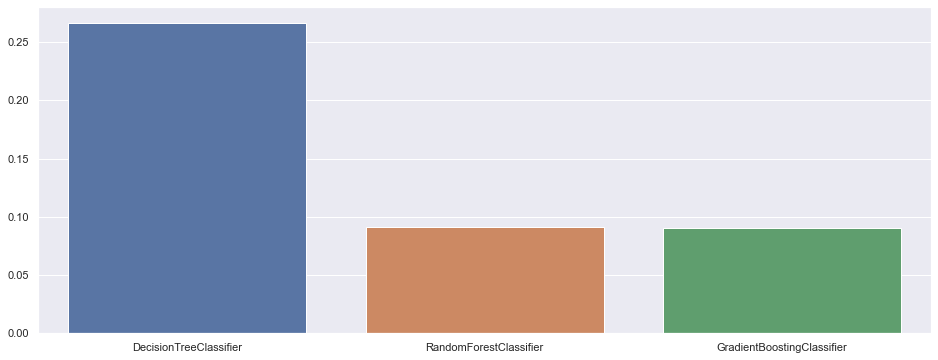

Average f1 for DecisionTreeClassifier: 0.2667244744581546
Average f1 for RandomForestClassifier: 0.09118698779917064
Average f1 for GradientBoostingClassifier: 0.08999596360830066


In [18]:
cv_scores = [dt_score, rf_score, gb_score]
plt.figure(figsize=(16, 6))
sns.barplot(x=['DecisionTreeClassifier', 'RandomForestClassifier', 'GradientBoostingClassifier'], y=cv_scores)
plt.show()

print('Average {} for DecisionTreeClassifier: {}'.format(metric, dt_score))
print('Average {} for RandomForestClassifier: {}'.format(metric, rf_score))
print('Average {} for GradientBoostingClassifier: {}'.format(metric, gb_score))

Based on this, we will select the `DecisionTreeClassifier`.

**Note** based on the `auc_roc` metric, we would have selected the `GradientBoostingClassifier` - try it out in the cells above to see and then compare the model performance later on.

We can also evaluate the impact of adding our weather features on model performance:

In [19]:
scores = cross_val_score(dt, X_train_cat, y_train, cv=5, scoring=metric)
cat_score = np.mean(scores)

scores = cross_val_score(dt, X_train_num, y_train, cv=5, scoring=metric)
num_score = np.mean(scores)

scores = cross_val_score(dt, X_train, y_train, cv=5, scoring=metric)
all_score = np.mean(scores)

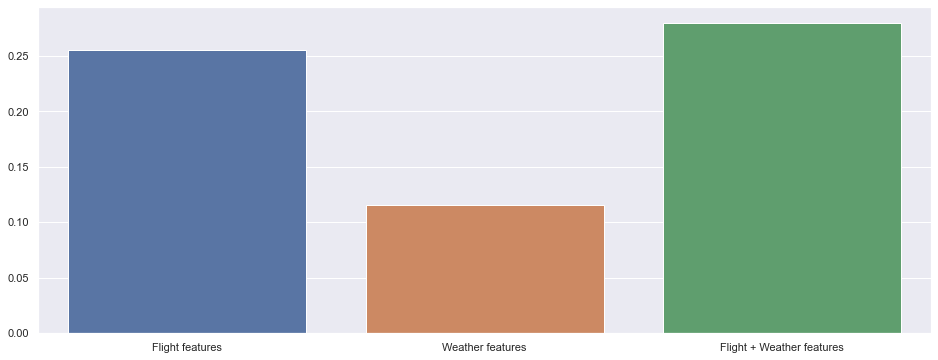

Average f1 for only flight delay features: 0.25514557033113305
Average f1 for only weather features: 0.11530678520395746
Average f1 for all features: 0.28007599914945136


In [20]:
cv_scores = [cat_score, num_score, all_score]
plt.figure(figsize=(16, 6))
sns.barplot(x=['Flight features', 'Weather features', 'Flight + Weather features'], y=cv_scores)
plt.show()

print('Average {} for only flight delay features: {}'.format(metric, cat_score))
print('Average {} for only weather features: {}'.format(metric, num_score))
print('Average {} for all features: {}'.format(metric, all_score))

We see that using only weather features does little better than random guessing, while adding weather features to the flight features increases our metric by around `0.01`. This is not a very large amount, but it does indicate that information about weather helps a little with predictions. In some applications, even small increases in model performance can be significant.

Finally, we re-train the model on the full training dataset and perform a final classification evaluation on the test set.

In [21]:
from sklearn.metrics import confusion_matrix, roc_auc_score, f1_score, classification_report
from sklearn.metrics import plot_roc_curve, plot_confusion_matrix, plot_precision_recall_curve

# fit on full data
dt.fit(X_train, y_train)
y_prob = dt.predict_proba(X_test)[:, 1]
y_pred = dt.predict(X_test)

f1_test = f1_score(y_test, y_prob)
roc_auc_test = roc_auc_score(y_test, y_prob)
print('Final {} for test set: {}'.format(metric, f1_test))

Final f1 for test set: 0.2662889518413598


We export the trained model and a few example rows from the test dataset, for potential use by downstream stages.

In [22]:
# save the model file for downstream tasks
from joblib import dump
dump(dt, '{}/model.joblib'.format(MODEL_EXPORT_FOLDER))

# also save a few example rows
np.save('data/test_rows.npy', X_test[:10])

In [24]:
# export metrics for KFP
metrics = {
    'metrics': [
        {
            'name': 'f1_score',
            'numberValue':  f1_test,
            'format': 'RAW'
        },
        {
            'name': 'roc_auc_score',
            'numberValue':  roc_auc_test,
            'format': 'RAW'       
        }
    ]
  }

with open('mlpipeline-metrics.json', 'w') as f:
    json.dump(metrics, f)

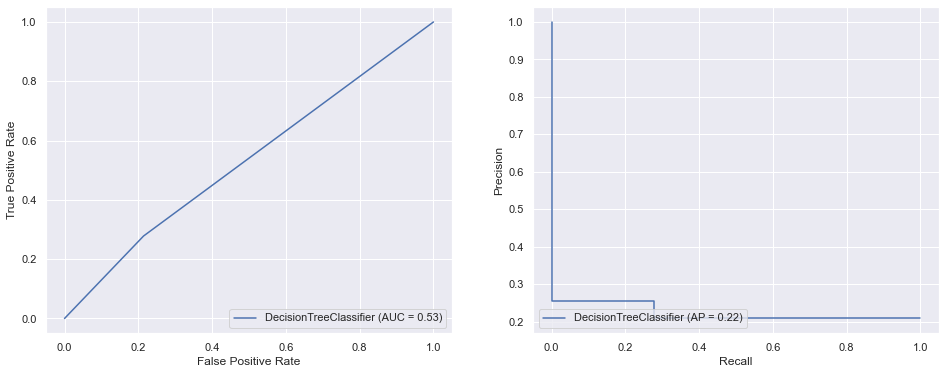

In [25]:
fig = plt.figure(figsize=(16, 6))
plt.subplot(121)
plot_roc_curve(dt, X_test, y_test, ax=fig.gca())
plt.subplot(122)
plot_precision_recall_curve(dt, X_test, y_test, ax=fig.gca())
plt.show()

In [26]:
print(classification_report(y_test, y_pred, target_names=['On-time', 'Delayed']))

              precision    recall  f1-score   support

     On-time       0.80      0.79      0.80      1279
     Delayed       0.26      0.28      0.27       338

    accuracy                           0.68      1617
   macro avg       0.53      0.53      0.53      1617
weighted avg       0.69      0.68      0.68      1617



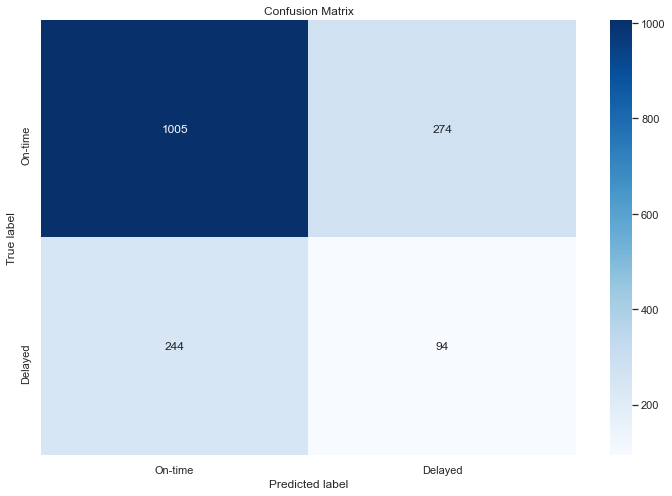

In [27]:
cm = confusion_matrix(y_test, y_pred)
class_labels = ['On-time', 'Delayed']
labels = ['{0:0.0f}'.format(value) for value in
                cm.flatten()]
labels = np.asarray(labels).reshape(2,2)
fig = plt.figure(figsize=(12, 8))
chart = sns.heatmap(
    cm, annot=labels, fmt='', cmap='Blues',
    xticklabels=class_labels, yticklabels=class_labels)
chart.set_xlabel('Predicted label')
chart.set_ylabel('True label')
chart.set_title('Confusion Matrix')
plt.show()

In [28]:
# export confusion matrix for KFP
cm_data = []
for target_index, target_row in enumerate(cm):
    for predicted_index, count in enumerate(target_row):
        cm_data.append((class_labels[target_index], class_labels[predicted_index], count))
        
ui_metadata = {
    'outputs' : [{
        'type': 'confusion_matrix',
        'format': 'csv',
        'schema': [
            {'name': 'target', 'type': 'CATEGORY'},
            {'name': 'predicted', 'type': 'CATEGORY'},
            {'name': 'count', 'type': 'NUMBER'},
        ],
        'source': pd.DataFrame(cm_data).to_csv(header=False, index=False),
        'storage': 'inline',
        'labels': ['Delayed', 'On-time'],
    }]
}

with open('mlpipeline-ui-metadata.json', 'w') as f:
    json.dump(ui_metadata, f)

If we investigate the various classification charts and reports, we can see that our problem of classifying whether a flight will be delayed is a tricky one.

As one might expect, the model predicts most `on-time` flights as `on-time` (80%). However, it struggles to correctly predict `delayed` flights, instead classifying them as `on-time`. In fact it only correctly predicts delays 28% of the time! (this is the `recall` figure for `Delayed` in the classification report table). When it predicts a delayed flight, it is correct only 25% of the time (this is the `precision` field).

Overall, we would say that our model is doing a mediocre job of predicting flight delays - we either need to do a lot more model tuning and hyper-parameter selection, or use more data and better features.

Perhaps you can try to find ways to improve the performance!

Finally, we can generate a list of "feature importances" to see what the model is focusing on for making predictions:

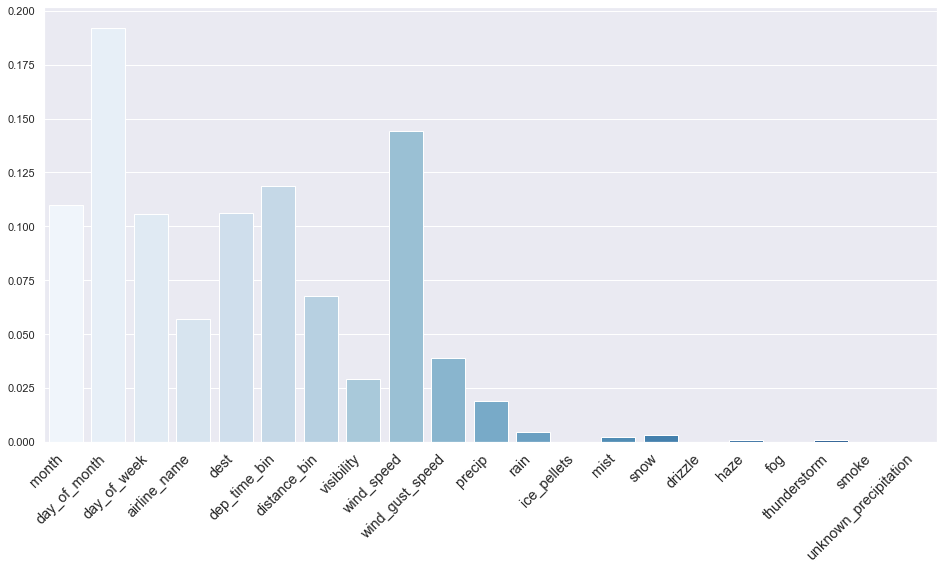

In [29]:
feat_names = list(df_train_cat.columns.values) + list(df_train[num_columns].columns.values)
feat_nb = dt.feature_importances_
plt.figure(figsize=(16, 8))
chart = sns.barplot(x=feat_names, y=feat_nb, palette='Blues')
chart.set_xticklabels(
    chart.get_xticklabels(), 
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='large'
)
plt.show()

Of the flight features, the time-based features as well as departure time and destination seem to be most important. For weather features, wind speed and visibility seem to be dominant in importance.

### Authors
This notebook was created by the [Center for Open-Source Data & AI Technologies](http://codait.org).

Copyright © 2019 IBM. This notebook and its source code are released under the terms of the MIT License.